#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
df = pd.read_csv('data01_train.csv')

In [4]:
df.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING


In [5]:
feature_df = pd.read_csv('features_fixed.csv')
feature = feature_df.copy()

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [7]:
df['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [8]:
df.drop('subject',axis=1, inplace=True)

In [9]:
label_dict = {
    'STANDING': 0,
    'LAYING': 1,
    'WALKING': 2,
    'WALKING_DOWNSTAIRS': 3,
    'WALKING_UPSTAIRS': 4,
    'SITTING':5
}
df1 = df.replace({'Activity': label_dict}).copy()

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
# le = LabelEncoder()
# df['Activity'] = le.fit_transform(df['Activity'])

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

<AxesSubplot:xlabel='Activity', ylabel='count'>

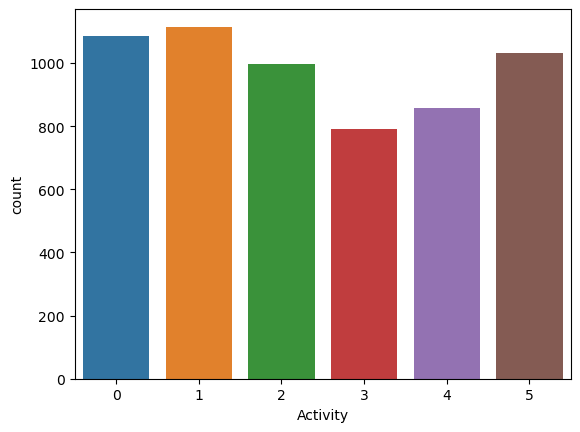

In [12]:
sns.countplot(x="Activity", data=df1)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [13]:
df1.isnull().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

In [14]:
t = df1.count()
c=0
for i in t:
    if i !=5881:
        c+=1
print(c)

0


In [15]:
feature['count_value'] = 5881

In [16]:
feature.head(3)

,sensor,agg,axis,feature_name,count_value
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,5881
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,5881
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,5881


In [17]:
sensor = pd.DataFrame(feature.groupby('sensor')['count_value'].sum())
sensor.reset_index(inplace=True)

<AxesSubplot:xlabel='sensor', ylabel='count_value'>

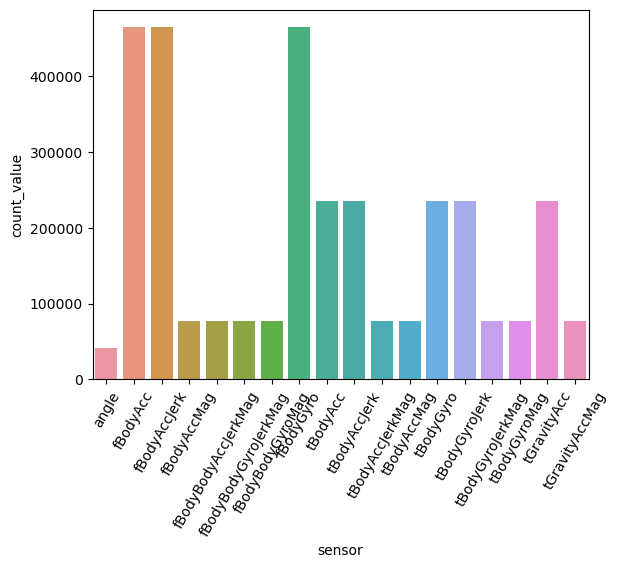

In [18]:
plt.xticks(rotation=60)
sns.barplot(x='sensor',y='count_value',data=sensor)

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [19]:
target='Activity'
x = df1.drop(target, axis=1)
y = df1[target]

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=1)

In [21]:
model = RandomForestClassifier()

In [22]:
model.fit(x_train,y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       235
           1       1.00      1.00      1.00       222
           2       0.99      0.98      0.99       192
           3       0.97      0.99      0.98       156
           4       0.98      0.99      0.98       174
           5       0.95      0.96      0.96       198

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



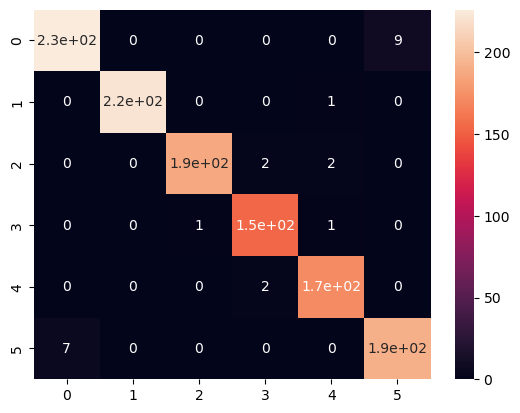

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# y값을 예측하여 confusion matrix를 구하고 heatmap 그래프로 시각화
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [24]:
# 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
# 입력 :
# importance : 트리모델의 변수 중요도(예: model.feature_importances_)
# names : 변수 이름 목록(예 : x_train.columns
# result_only : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
# topn : 중요도 상위 n개만 표시. all 이면 전체.
# 출력 :
# 중요도 그래프 : 중요도 내림차순으로 정렬
# 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [25]:
result_df = plot_feature_importance(model.feature_importances_, x_train.columns, result_only = True, topn = 'all')

In [26]:
# topic = 'all'
# importance_df.rename(columns = {'feature_importance':topic},inplace=True)
# importance_df

In [27]:
# plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 5)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [31]:
#기존의 features.csv 해결 방법
# fea = model.feature_importances_
# na = x_train.columns

# df = pd.DataFrame([ x for x in zip(na,fea)])
# df.columns = ['feature_name', 'feature_importance']
# feature['feature_name'] = df['feature_name']
feature1 = pd.merge(feature, result_df, on='feature_name')


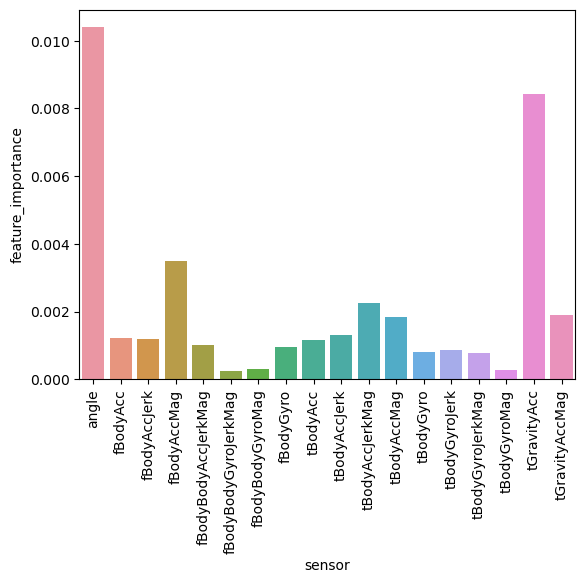

In [32]:
importance = pd.DataFrame(feature1.groupby('sensor')['feature_importance'].mean())
importance.reset_index(inplace=True)
plt.xticks(rotation=90)
sns.barplot(x='sensor',y='feature_importance',data=importance)
plt.show()

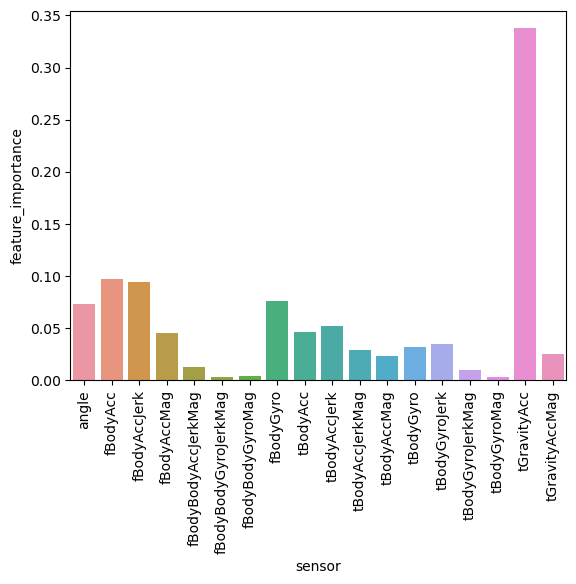

In [33]:
importance = pd.DataFrame(feature1.groupby('sensor')['feature_importance'].sum())
importance.reset_index(inplace=True)
plt.xticks(rotation=90)
sns.barplot(x='sensor',y='feature_importance',data=importance)
plt.show()

In [34]:
sensor_agg = pd.DataFrame(feature1.groupby(['sensor','agg'])['feature_importance'].sum())
sensor_agg.reset_index(inplace=True)

In [35]:
sensor_agg['sensorAgg'] = sensor_agg['sensor']+'_'+sensor_agg['agg']

In [36]:
# sensor_agg.sort_values(by='feature_importance', ascending=False)[:10]

In [37]:
topic = 'all'
result_df.rename(columns = {'feature_importance':topic},inplace=True)
sensor_agg.rename(columns = {'feature_importance':topic},inplace=True)

In [38]:
sensor_agg.drop(['sensor','agg'],axis=1, inplace=True)

In [39]:
sensor_agg

,all,sensorAgg
0,0.029588,angle_X
1,0.032694,angle_Y
2,0.008629,angle_Z
3,0.000088,angle_tBodyAccJerkMean
4,0.000142,angle_tBodyAccMean
...,...,...
216,0.002090,tGravityAccMag_max()
217,0.001420,tGravityAccMag_mean()
218,0.000138,tGravityAccMag_min()
219,0.000183,tGravityAccMag_sma()


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [40]:
df2 = df.copy()

In [41]:
df2['is_dynamic'] = df2['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_DOWNSTAIRS': 1,
    'WALKING_UPSTAIRS': 1,
    'SITTING':0
}
df2 = df2.replace({'is_dynamic': label_dict}).copy()

#### 2) 기본모델 생성

In [42]:
df2.drop('Activity', axis=1, inplace=True)
target = 'is_dynamic'
x = df2.drop(target, axis=1)
y = df2[target]

In [43]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=1)

In [44]:
model = RandomForestClassifier()

In [45]:
model.fit(x_train,y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

In [46]:
y_pred = model.predict(x_val)

,feature_name,feature_importance
0,fBodyAccJerk-entropy()-X,0.069940
1,tBodyAccJerk-std()-X,0.060145
2,"fBodyAccJerk-bandsEnergy()-1,24",0.059984
3,fBodyAccJerk-max()-X,0.040009
4,tBodyAccJerkMag-entropy(),0.039940


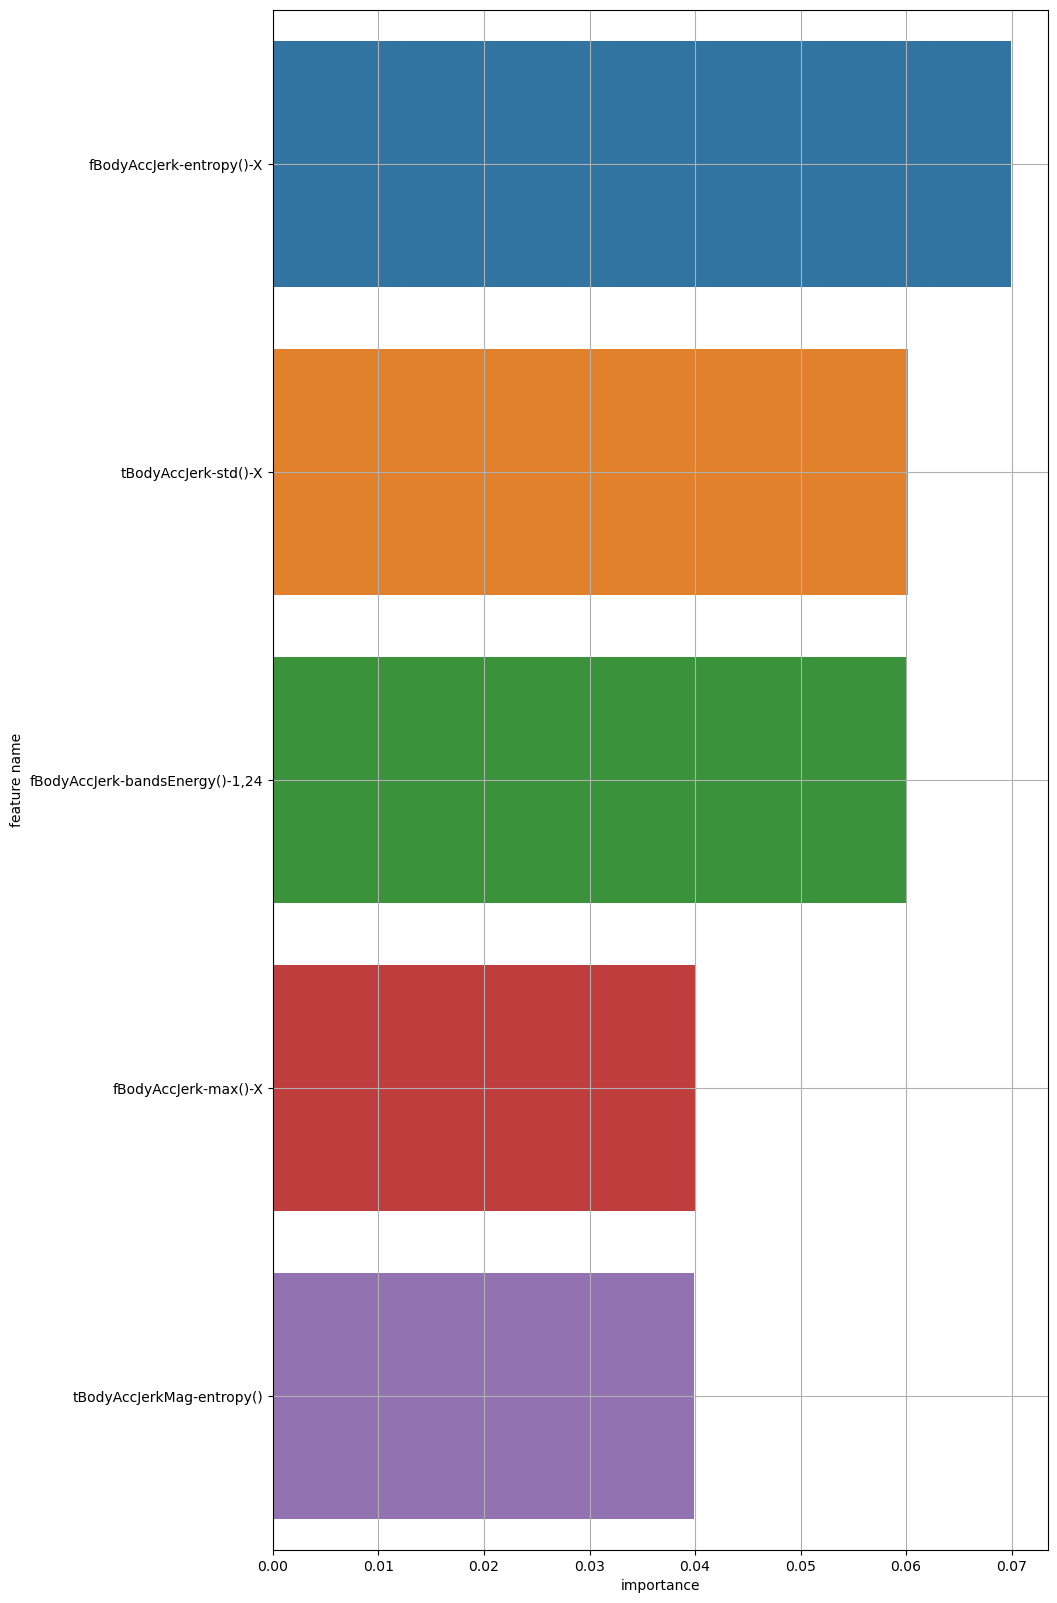

In [47]:
plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 5)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



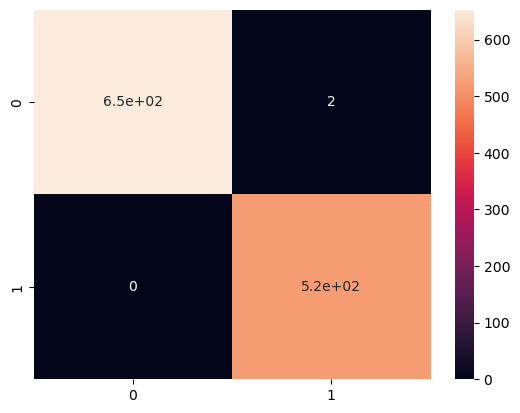

In [48]:
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

In [49]:
dynamic_result = plot_feature_importance(model.feature_importances_, x_train.columns, result_only = True, topn = 'all')

In [50]:
# sensor_agg.loc[:,['sensor_agg', 'feature_importance']].sort_values(by='feature_importance', ascending=False)[:5]

#### 4) feature 그룹별 분석

In [51]:
def feature_analysis(importances_,columns, feature, topic='all'):
    importance_df = plot_feature_importance(importances_, columns, result_only = True, topn = 'all')
    
    print("="*50)
    print("Top 5: Importance Features")
    print(plot_feature_importance(model.feature_importances_, columns, result_only = True, topn = 5))
    plt.show()
    print("="*50)
    feature_df = pd.merge(feature, importance_df, on='feature_name')
    print("Importance of Features group by sensor")
    importance = pd.DataFrame(feature_df.groupby('sensor')['feature_importance'].sum())
    importance.reset_index(inplace=True)
    plt.xticks(rotation=90)
    sns.barplot(x='sensor',y='feature_importance',data=importance)
    plt.show()
    print("="*50)
    print("Importance of Features group by sensor+agg")
    sensor_agg1 = pd.DataFrame(feature_df.groupby(['sensor','agg'])['feature_importance'].sum())
    sensor_agg1.reset_index(inplace=True)
    sensor_agg1['sensorAgg'] = sensor_agg1['sensor']+'_'+sensor_agg1['agg']
    print(sensor_agg1.loc[:,['sensorAgg', 'feature_importance']].sort_values(by='feature_importance', ascending=False)[:5])
    
    importance_df.rename(columns = {'feature_importance':topic},inplace=True)
    sensor_agg1.rename(columns = {'feature_importance':topic},inplace=True)
    return importance_df, sensor_agg1.loc[:,[topic, 'sensorAgg']]

Top 5: Importance Features
                      feature_name  feature_importance
0         fBodyAccJerk-entropy()-X            0.069940
1             tBodyAccJerk-std()-X            0.060145
2  fBodyAccJerk-bandsEnergy()-1,24            0.059984
3             fBodyAccJerk-max()-X            0.040009
4        tBodyAccJerkMag-entropy()            0.039940
Importance of Features group by sensor


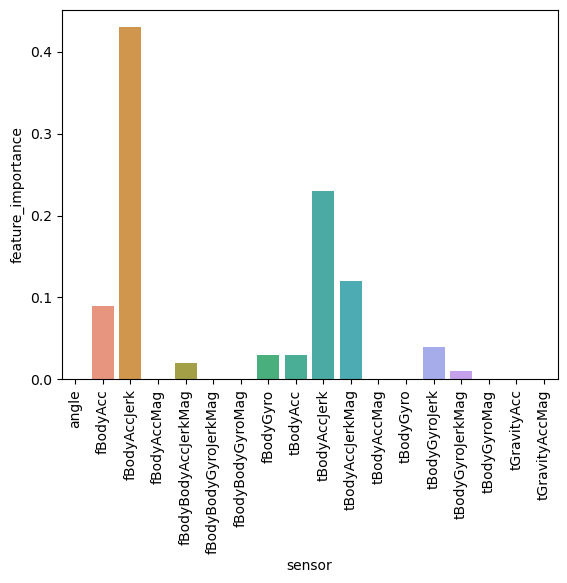

Importance of Features group by sensor+agg
                      sensorAgg  feature_importance
21   fBodyAccJerk_bandsEnergy()            0.149922
122          tBodyAccJerk_std()            0.070094
23       fBodyAccJerk_entropy()            0.069949
27           fBodyAccJerk_max()            0.059839
117          tBodyAccJerk_mad()            0.039965


In [52]:
target = 'is_dynamic'
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [53]:
df3 = df.copy()
df3['is_standing'] = df3['Activity']
label_dict = {
    'STANDING': 1,
    'LAYING': 0,
    'WALKING': 0,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 0,
    'SITTING':0
}
df3 = df3.replace({'is_standing': label_dict}).copy()
df3.drop('Activity', axis=1, inplace=True)

<AxesSubplot:xlabel='is_standing', ylabel='count'>

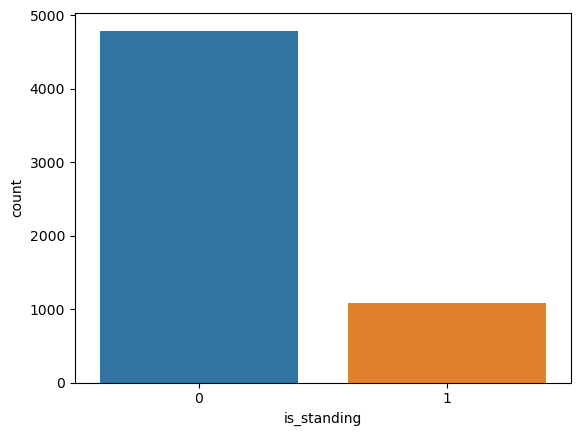

In [54]:
sns.countplot(x='is_standing', data=df3)

In [55]:
target='is_standing'
def split_train_val(data, target):
    x = data.drop(target,axis=1)
    y = data[target]
    return train_test_split(x,y, test_size=0.2, random_state=1)

In [56]:
x_train,x_val, y_train,y_val = split_train_val(df3, target)

Top 5: Importance Features
           feature_name  feature_importance
0   tGravityAcc-max()-Y            0.052952
1  angle(Y,gravityMean)            0.047946
2   tGravityAcc-min()-Y            0.041049
3  tGravityAcc-mean()-Y            0.035153
4   tGravityAcc-min()-Z            0.027543
Importance of Features group by sensor


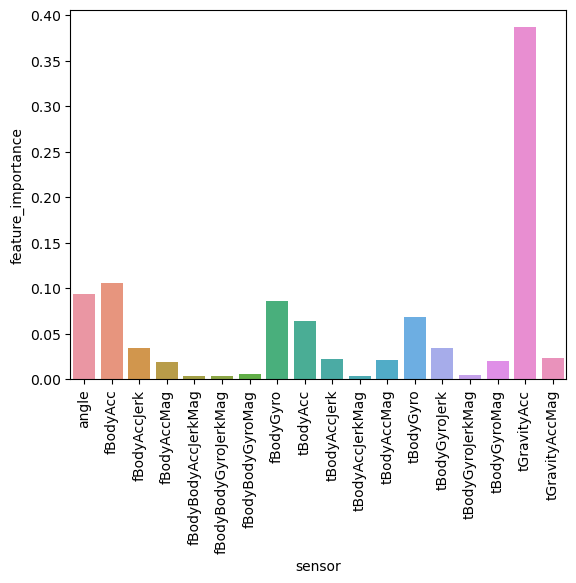

Importance of Features group by sensor+agg
                sensorAgg  feature_importance
203     tGravityAcc_max()            0.103979
205     tGravityAcc_min()            0.082927
204    tGravityAcc_mean()            0.075667
199  tGravityAcc_energy()            0.052905
1                 angle_Y            0.047946
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       942
           1       0.97      0.97      0.97       235

    accuracy                           0.99      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.99      0.99      0.99      1177



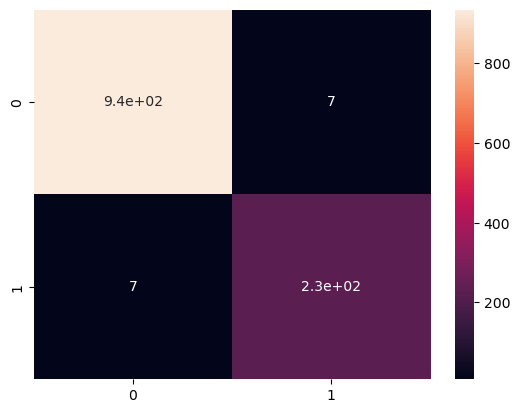

In [57]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [58]:
target='is_sitting'
df4 = df.copy()
df4[target] = df4['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 0,
    'WALKING': 0,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 0,
    'SITTING':1
}
df4 = df4.replace({target: label_dict}).copy()
df4.drop('Activity', axis=1, inplace=True)

<AxesSubplot:xlabel='is_sitting', ylabel='count'>

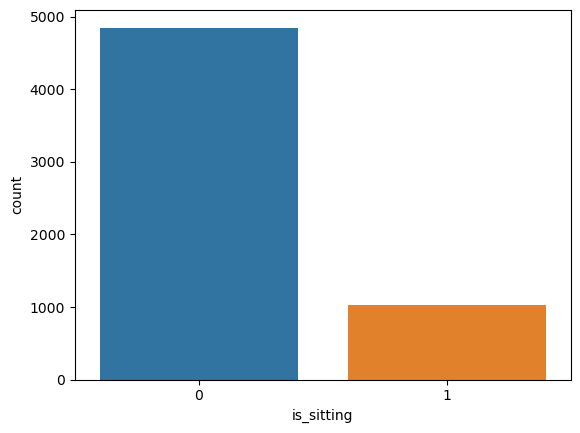

In [59]:
sns.countplot(x=target, data=df4)

In [60]:
x_train,x_val, y_train,y_val = split_train_val(df4, target)

Top 5: Importance Features
             feature_name  feature_importance
0    angle(Y,gravityMean)            0.049507
1    tGravityAcc-mean()-Y            0.047058
2     tGravityAcc-min()-Y            0.037575
3     tGravityAcc-max()-Y            0.035887
4  tGravityAcc-energy()-X            0.034079
Importance of Features group by sensor


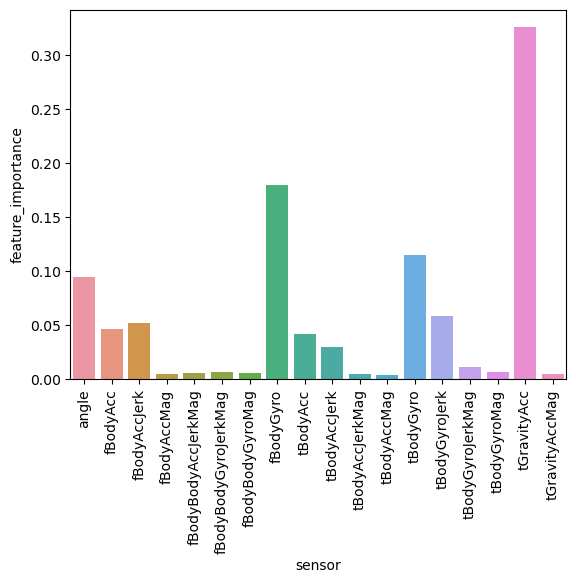

Importance of Features group by sensor+agg
                   sensorAgg  feature_importance
87   fBodyGyro_bandsEnergy()            0.087522
204       tGravityAcc_mean()            0.087464
205        tGravityAcc_min()            0.073077
203        tGravityAcc_max()            0.066807
199     tGravityAcc_energy()            0.057433
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.97      0.96      0.97       198

    accuracy                           0.99      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.99      0.99      0.99      1177



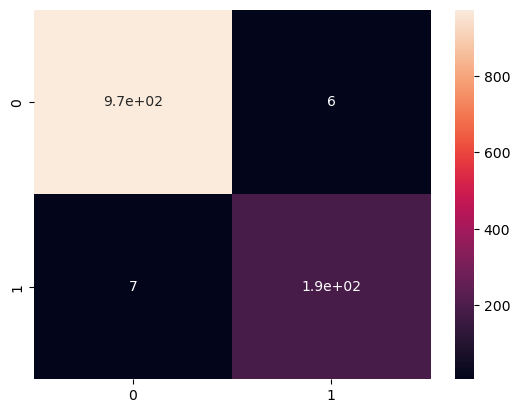

In [61]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


<AxesSubplot:xlabel='is_laying', ylabel='count'>

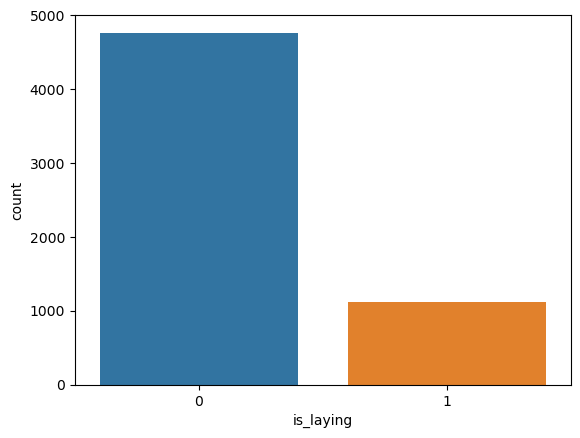

In [62]:
target='is_laying'
df5 = df.copy()
df5[target] = df5['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 1,
    'WALKING': 0,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 0,
    'SITTING':0
}
df5 = df5.replace({target: label_dict}).copy()
df5.drop('Activity', axis=1, inplace=True)
sns.countplot(x=target, data=df5)

Top 5: Importance Features
             feature_name  feature_importance
0     tGravityAcc-min()-X            0.103456
1  tGravityAcc-energy()-X            0.094986
2    tGravityAcc-mean()-Y            0.094533
3    tGravityAcc-mean()-X            0.088378
4    angle(X,gravityMean)            0.083567
Importance of Features group by sensor


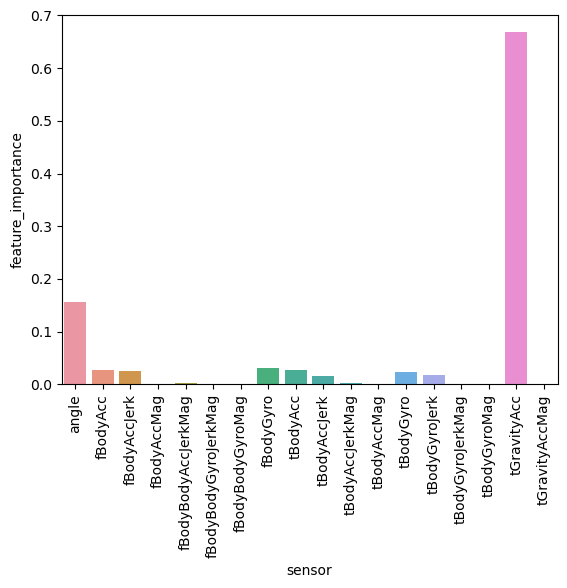

Importance of Features group by sensor+agg
                sensorAgg  feature_importance
204    tGravityAcc_mean()            0.199330
205     tGravityAcc_min()            0.189218
199  tGravityAcc_energy()            0.164925
203     tGravityAcc_max()            0.092052
0                 angle_X            0.083567
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       955
           1       1.00      1.00      1.00       222

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



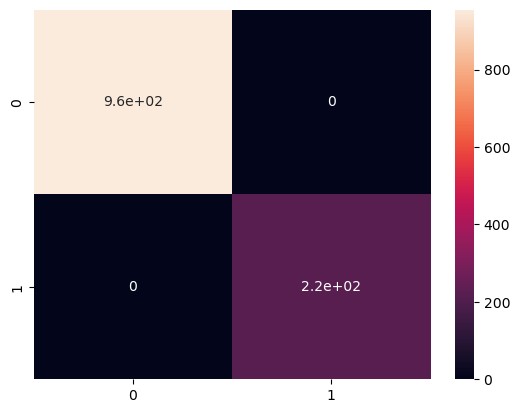

In [63]:
x_train,x_val, y_train,y_val = split_train_val(df5, target)

model = RandomForestClassifier()
model.fit(x_train,y_train)

temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


<AxesSubplot:xlabel='is_walking', ylabel='count'>

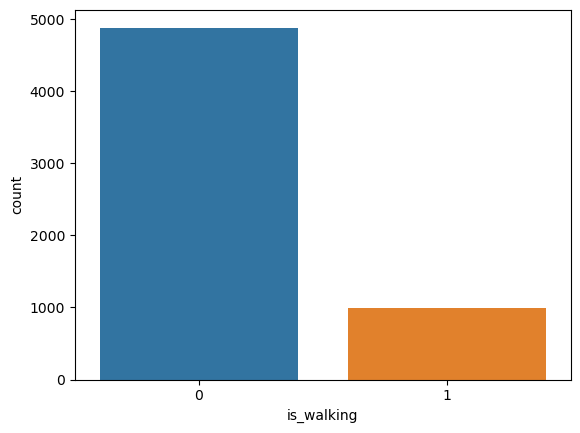

In [64]:
target='is_walking'
df6 = df.copy()
df6[target] = df6['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 0,
    'SITTING':0
}
df6 = df6.replace({target: label_dict}).copy()
df6.drop('Activity', axis=1, inplace=True)
sns.countplot(x=target, data=df6)

Top 5: Importance Features
                 feature_name  feature_importance
0  fBodyAcc-bandsEnergy()-1,8            0.024117
1           fBodyAccMag-std()            0.023250
2            fBodyAcc-max()-X            0.022091
3  tBodyAcc-correlation()-X,Y            0.020712
4           fBodyAccMag-mad()            0.019907
Importance of Features group by sensor


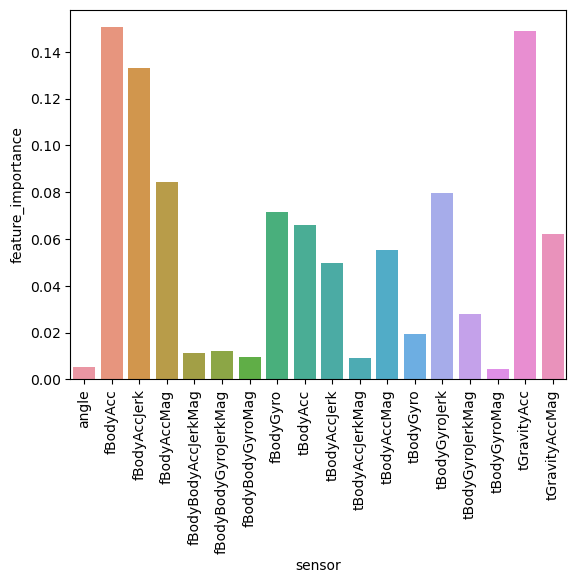

Importance of Features group by sensor+agg
                      sensorAgg  feature_importance
197       tGravityAcc_arCoeff()            0.104496
7        fBodyAcc_bandsEnergy()            0.087985
21   fBodyAccJerk_bandsEnergy()            0.064584
87      fBodyGyro_bandsEnergy()            0.047640
47            fBodyAccMag_std()            0.023250
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       985
           1       1.00      0.96      0.98       192

    accuracy                           0.99      1177
   macro avg       1.00      0.98      0.99      1177
weighted avg       0.99      0.99      0.99      1177



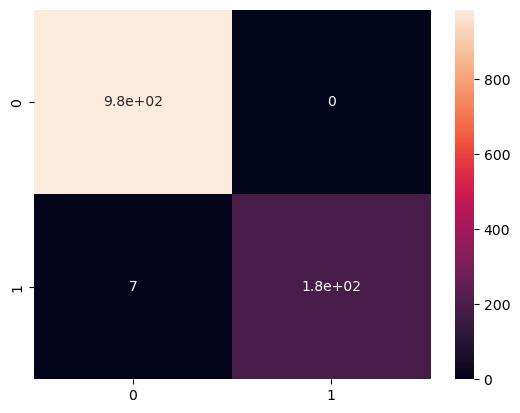

In [65]:
x_train,x_val, y_train,y_val = split_train_val(df6, target)

model = RandomForestClassifier()
model.fit(x_train,y_train)
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


<AxesSubplot:xlabel='is_walking_up', ylabel='count'>

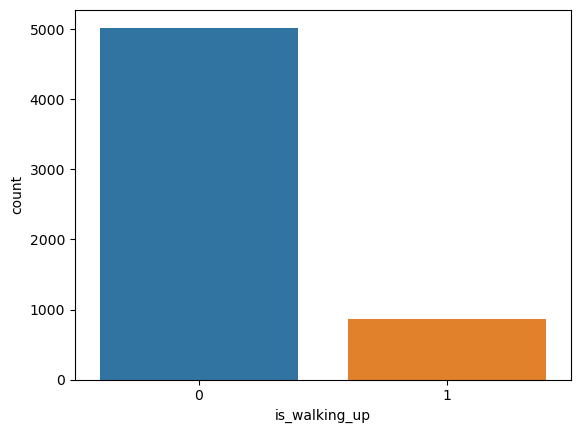

In [66]:
target='is_walking_up'
df7 = df.copy()
df7[target] = df7['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 0,
    'WALKING': 0,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 1,
    'SITTING':0
}
df7 = df7.replace({target: label_dict}).copy()
df7.drop('Activity', axis=1, inplace=True)
sns.countplot(x=target, data=df7)

Top 5: Importance Features
                   feature_name  feature_importance
0     tGravityAcc-arCoeff()-Z,2            0.039325
1  fBodyAcc-bandsEnergy()-1,8.2            0.036373
2           tGravityAcc-min()-Y            0.026376
3     tGravityAcc-arCoeff()-Y,1            0.025039
4          angle(Y,gravityMean)            0.023853
Importance of Features group by sensor


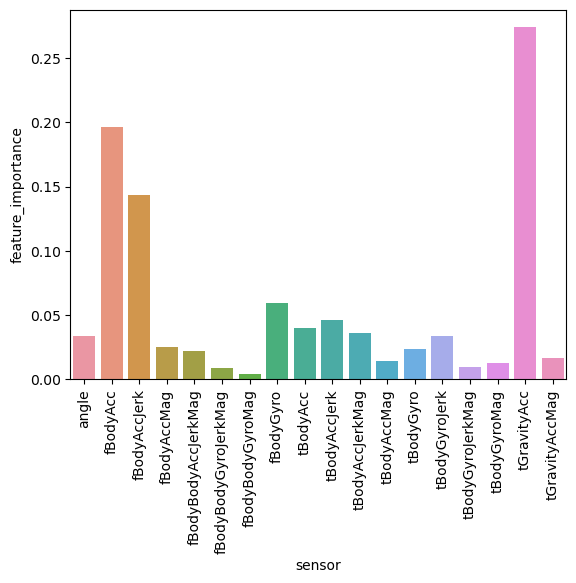

Importance of Features group by sensor+agg
                      sensorAgg  feature_importance
197       tGravityAcc_arCoeff()            0.163619
7        fBodyAcc_bandsEnergy()            0.095093
21   fBodyAccJerk_bandsEnergy()            0.065216
205           tGravityAcc_min()            0.037256
13               fBodyAcc_max()            0.029623
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       0.98      0.99      0.99       174

    accuracy                           1.00      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       1.00      1.00      1.00      1177



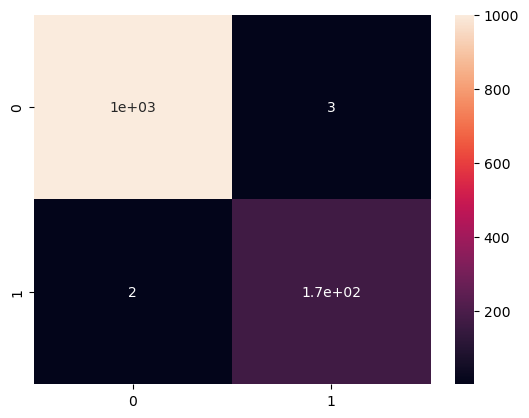

In [67]:
x_train,x_val, y_train,y_val = split_train_val(df7, target)

model = RandomForestClassifier()
model.fit(x_train,y_train)
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


<AxesSubplot:xlabel='is_walking_down', ylabel='count'>

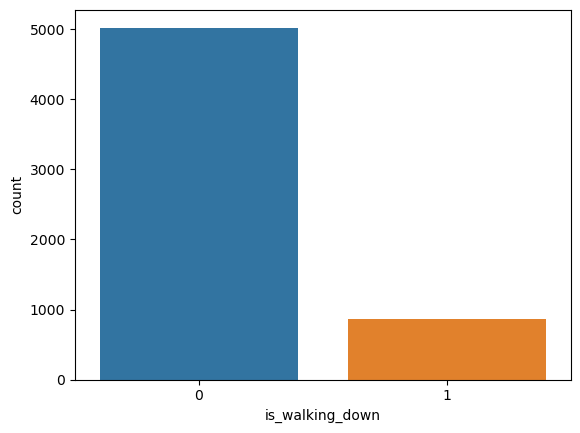

In [68]:
target='is_walking_down'
df8 = df.copy()
df8[target] = df8['Activity']
label_dict = {
    'STANDING': 0,
    'LAYING': 0,
    'WALKING': 0,
    'WALKING_DOWNSTAIRS': 0,
    'WALKING_UPSTAIRS': 1,
    'SITTING':0
}
df8 = df8.replace({target: label_dict}).copy()
df8.drop('Activity', axis=1, inplace=True)
sns.countplot(x=target, data=df8)

Top 5: Importance Features
                   feature_name  feature_importance
0          tGravityAcc-mean()-Y            0.033618
1           tGravityAcc-min()-Y            0.026728
2     tGravityAcc-arCoeff()-Y,2            0.026679
3  fBodyAcc-bandsEnergy()-1,8.1            0.024486
4     tGravityAcc-arCoeff()-Z,1            0.021609
Importance of Features group by sensor


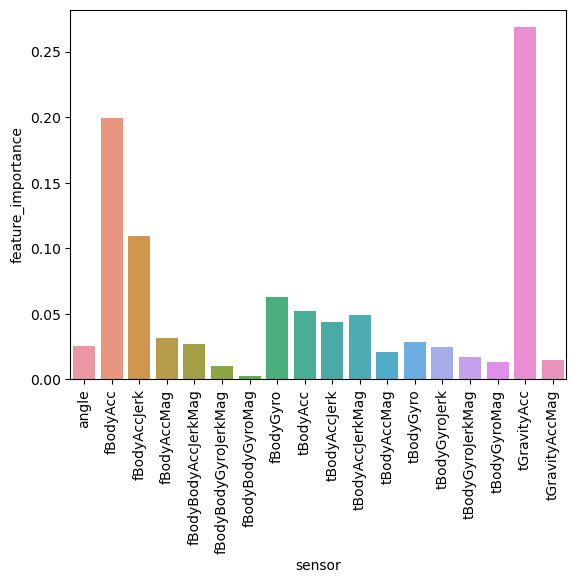

Importance of Features group by sensor+agg
                      sensorAgg  feature_importance
197       tGravityAcc_arCoeff()            0.143697
7        fBodyAcc_bandsEnergy()            0.107148
204          tGravityAcc_mean()            0.041763
205           tGravityAcc_min()            0.036217
21   fBodyAccJerk_bandsEnergy()            0.034798
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1003
           1       0.99      0.99      0.99       174

    accuracy                           1.00      1177
   macro avg       0.99      1.00      0.99      1177
weighted avg       1.00      1.00      1.00      1177



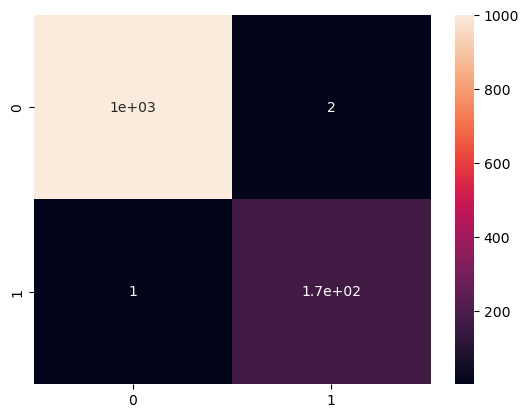

In [69]:
x_train,x_val, y_train,y_val = split_train_val(df8, target)

model = RandomForestClassifier()
model.fit(x_train,y_train)
temp1, temp2 = feature_analysis(model.feature_importances_, x_train.columns, feature, topic=target)
result_df = pd.merge(result_df, temp1, on='feature_name')
sensor_agg = pd.merge(sensor_agg, temp2, on='sensorAgg')
    
y_pred = model.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True)

# Scikit-learn의 classification_report를 활용하여 성능을 출력
print(classification_report(y_val, y_pred))

In [70]:
# result_df.drop('is_dynamic_y',axis=1, inplace=True)

In [71]:
# sensor_agg.drop('is_dynamic_y',axis=1, inplace=True)

In [72]:
# result_df.rename(columns = {'is_dynamic_x':'is_dynamic'},inplace=True)
# sensor_agg.rename(columns = {'is_dynamic_x':'is_dynamic'},inplace=True)

In [73]:
result_df

,feature_name,all,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up,is_walking_down
0,tGravityAcc-min()-X,0.036034,0.000021,0.014335,0.022232,0.103456,0.005575,0.008198,0.006432
1,"angle(Y,gravityMean)",0.032694,0.000000,0.047946,0.049507,0.050556,0.001851,0.023853,0.016021
2,tGravityAcc-energy()-X,0.032610,0.000000,0.018413,0.034079,0.094986,0.003857,0.006923,0.005957
3,tGravityAcc-mean()-X,0.030755,0.000009,0.021443,0.025625,0.088378,0.000562,0.003173,0.003560
4,"angle(X,gravityMean)",0.029588,0.000034,0.021500,0.033476,0.083567,0.002630,0.004202,0.007055
...,...,...,...,...,...,...,...,...,...
556,"fBodyAccJerk-bandsEnergy()-49,56",0.000069,0.000000,0.000362,0.000174,0.000000,0.000322,0.000201,0.000192
557,"tBodyGyro-arCoeff()-Z,2",0.000064,0.000000,0.000431,0.000583,0.000013,0.000168,0.000163,0.000151
558,fBodyBodyGyroJerkMag-entropy(),0.000058,0.000000,0.000132,0.000374,0.000000,0.000196,0.000366,0.000283
559,"tBodyAcc-arCoeff()-Y,3",0.000050,0.000000,0.000234,0.000289,0.000026,0.000088,0.000014,0.000114


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [74]:
import joblib
joblib.dump(result_df, 'result_df.pkl')
joblib.dump(sensor_agg, 'sensor_agg.pkl')

['sensor_agg.pkl']